## **Week 9: Capstone Development**

**Gradient Boosting**

### **Progress so far:**

So far, we have experimented with models like Logistic Regression, SVM Classifiers, Decision Trees, and Random Forests on a binary classification task. The main idea of the exercise is to be able to predict, from conditions on the field, whether a given play in the NFL will lead to an injury, and then use this information to be able to cut down on injuries in the national football league. 

**Problems so far:** 

Although there was some initial luck with logistic regression, the dataset is characterized by two main challenges: 
1. A high number of sparse one-hot encoded variables.
2. An extreme class imbalance. Only 2.5% of plays lead to an injury. 


While tree based models initially seemed like a good fit for these challlenges, thus far tree based models have all struggled with overfitting with "Accuracy" metrics in cross validation reflecting the model picking 'no injury' every time and balanced accuracy metrics barely outperforming random guessing.  Here we investigate whether tree-based models that are specifically built for extreme imbalance (XGBoost) and sparse categorical variables (CatBoost) will ameliorate these challenges. 

In [1]:
# Standard Libraries
import os
import time
import math
import io
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars
import seaborn as sns
import matplotlib.pyplot as plt



# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    RepeatedKFold
)

from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, root_mean_squared_error, accuracy_score, f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LogisticRegression, Lasso, RidgeClassifier, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.ensemble        import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
# from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, RUSBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


# Progress Tracking
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

#### **Dataset Imports**

In [63]:
# Base Datasets
BDB_All_Plays_Model_Ready = pd.read_csv("../../BDB_All_Plays_Model_Ready.csv") # Big Data Bowl Dataset


# PCA and Standardized Datasets
BDB_PCA_Features = pd.read_csv('../../Feature_Subsets/BDB_PCA_Features.csv')


pda_all_plays_clean_numeric = pd.read_csv("../../Feature_Subsets/BDB_All_Plays_Clean_Categorical.csv")


In [2]:
# Base Datasets
BDB_All_Plays_Model_Ready = pd.read_csv("../../BDB_All_Plays_Model_Ready.csv") # Big Data Bowl Dataset
PDA_Model_Ready = pd.read_csv("../../PDA_Model_Ready.csv") # Punt Data Analytics
FNF_Model_Ready = pd.read_csv("../../FNF_Model_Ready.csv") # First and Future


# PCA and Standardized Datasets
PDA_PCA_Features = pd.read_csv('../../Feature_Subsets/PDA_PCA_Features.csv')
FNF_PCA_Features = pd.read_csv('../../Feature_Subsets/FNF_PCA_Features.csv')
BDB_PCA_Features = pd.read_csv('../../Feature_Subsets/BDB_PCA_Features.csv')

#### **Useful Functions**

Once again, we will be using the train test split, the run_model_classifier, and the standardize features functions that we obtained originally from Module 3, and have since adapted in the weeks preceeding this. 

#### **Train Test Split**

In [5]:
# ===========================================================================================
# Function taken from Module 3 Final Project
# https://github.com/LeeMcFarling/Final_Project_Writeup/blob/main/Final_Project_Report.ipynb
# ===========================================================================================

def train_test_split_data(df, target_col):
    X = df.drop(columns=target_col)
    y = df[target_col]
# 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    return X_train, X_test, y_train, y_test

In [3]:

def train_test_split_data(df, target_col, test_size=0.2, random_state=42, do_stratify=True):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    stratify_vec = y if do_stratify and y.nunique() > 1 else None

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state,
        stratify=stratify_vec
    )
    return X_train, X_test, y_train, y_test

And using it to split the data: 

In [65]:

BDB_PCA_X_train, BDB_PCA_X_test, BDB_PCA_y_train, BDB_PCA_y_test = train_test_split_data(BDB_PCA_Features, 'Inj_Occured')

bdb_X_train, bdb_X_test, bdb_y_train, bdb_y_test = train_test_split_data(BDB_All_Plays_Model_Ready, 'Inj_Occured')


In [4]:
PDA_PCA_X_train, PDA_PCA_X_test, PDA_PCA_y_train, PDA_PCA_y_test = train_test_split_data(PDA_PCA_Features, 'Inj_Occured')
FNF_PCA_X_train, FNF_PCA_X_test, FNF_PCA_y_train, FNF_PCA_y_test = train_test_split_data(FNF_PCA_Features, 'Inj_Occured')
BDB_PCA_X_train, BDB_PCA_X_test, BDB_PCA_y_train, BDB_PCA_y_test = train_test_split_data(BDB_PCA_Features, 'Inj_Occured')

bdb_X_train, bdb_X_test, bdb_y_train, bdb_y_test = train_test_split_data(BDB_All_Plays_Model_Ready, 'Inj_Occured')
fnf_X_train, fnf_X_test, fnf_y_train, fnf_y_test = train_test_split_data(FNF_Model_Ready, 'Inj_Occured')
pda_X_train, pda_X_test, pda_y_train, pda_y_test = train_test_split_data(PDA_Model_Ready, 'Inj_Occured')

#### **Standardization Function**

In [5]:
# =============================================================================================
# Standardize Numeric Features
#
# Taken from Week 2.ipynb and modified to exclude the hard coded logic
#  
# Originally taken from Mod 3 final project found here: 
# https://github.com/LeeMcFarling/Final_Project_Writeup/blob/main/Final_Project_Report.ipynb
#
# =============================================================================================


def standardize_features(df, target_column=None, debug=False, return_scaler=False):
    df_scaled = df.copy()

    # 1) Automatically detect numeric columns
    numeric_cols = df.select_dtypes(include="number").columns.tolist()

    # 2) Remove target if present
    if target_column in numeric_cols:
        numeric_cols.remove(target_column)

    # 3) Exclude binary (0/1) columns
    numeric_cols_to_scale = [
        col for col in numeric_cols
        if df[col].nunique(dropna=True) > 2
    ]

    if debug:
        print("Numeric columns before filtering:", numeric_cols)
        print("Numeric columns after filtering:", numeric_cols_to_scale)

    # 4) Apply StandardScaler
    scaler = StandardScaler()
    if numeric_cols_to_scale:
        df_scaled[numeric_cols_to_scale] = scaler.fit_transform(df_scaled[numeric_cols_to_scale])

    if return_scaler:
        return df_scaled, scaler
    return df_scaled

And using this to scale our features: 

In [12]:

BDB_PCA_X_train_scaled = standardize_features(BDB_PCA_X_train)
BDB_PCA_X_test_scaled  = standardize_features(BDB_PCA_X_test)
# BDB_PCA_y_train
# BDB_PCA_y_test 



bdb_X_train_scaled = standardize_features(bdb_X_train)
bdb_X_test_scaled = standardize_features(bdb_X_test)
# bdb_y_train
# bdb_y_test 

fnf_X_train_scaled = standardize_features(fnf_X_train)
fnf_X_test_scaled = standardize_features(fnf_X_test) 
# fnf_y_train
# fnf_y_test 


pda_X_train_scaled = standardize_features(pda_X_train)
pda_X_test_scaled =  standardize_features(pda_X_test)
# pda_y_train
# pda_y_test 


#### **Run Model Classifier**

In [14]:
# =============================================================================================
# Taken from Mod 3 Week 8:
# https://github.com/waysnyder/Module-3-Assignments/blob/main/Homework_08.ipynb
# 
# Global dataframe logic taken from mod 3 final project: 
# https://github.com/LeeMcFarling/Final_Project_Writeup/blob/main/Final_Project_Report.ipynb
# 
# Final Function was developed in Week 2 of this Module
# =============================================================================================

def run_model_classifier(model, X_train, y_train, X_test, y_test, n_repeats=10, n_jobs=-1, run_comment=None, return_model=False, concat_results=False, **model_params):

    global combined_results
    # Remove extra key used to store error metric, if it was added to the parameter dictionary
    if 'accuracy_found' in model_params:
        model_params = model_params.copy()
        model_params.pop('accuracy_found', None)  
        
    # Instantiate the model if a class is provided
    if isinstance(model, type):
        model = model(**model_params)
    else:                                    
        model.set_params(**model_params)    

    model_name = model.__name__ if isinstance(model, type) else model.__class__.__name__ # Added because 


    # Use RepeatedStratifiedKFold for classification to preserve class distribution
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=42)
    
    # Perform 5-fold cross-validation using accuracy as the scoring metric
    cv_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=n_jobs)
    
    mean_cv_accuracy = np.mean(cv_scores)
    std_cv_accuracy  = np.std(cv_scores)
    
    # Fit the model on the full training set
    model.fit(X_train, y_train)
    
    # Compute training and testing accuracy
    train_preds    = model.predict(X_train)
    test_preds     = model.predict(X_test)

    # Normal Accuracy 
    train_accuracy = accuracy_score(y_train, train_preds)
    test_accuracy  = accuracy_score(y_test, test_preds)

    # Balanced Accuracy Metrics
    balanced_train_accuracy = balanced_accuracy_score(y_train, train_preds)
    balanced_test_accuracy = balanced_accuracy_score(y_test, test_preds)

    results_df = pd.DataFrame([{
        'model': model_name, 
        'model_params': model.get_params(),
        'mean_cv_accuracy': mean_cv_accuracy,
        'std_cv_accuracy': std_cv_accuracy,
        'train_accuracy': train_accuracy, 
        'test_accuracy': test_accuracy,
        'balanced_train_accuracy' : balanced_train_accuracy,
        'balanced_test_accuracy': balanced_test_accuracy,
        'run_comment': run_comment
    }])
    
    if concat_results:
        try:
            combined_results = pd.concat([combined_results, results_df], ignore_index=True)
        except NameError:
            combined_results = results_df

    return (results_df, model) if return_model else results_df

#### **Parameter Sweep**

Comes with a run_model function that was also adapted from module 3. 

In [71]:
def run_model(model, X_train, y_train, X_test, y_test, n_repeats=10, n_jobs=-1, **model_params):

    # Remove extra key used to store error metric, if it was added to the parameter dictionary
    
    if 'accuracy_found' in model_params:
        model_params = model_params.copy()
        model_params.pop('accuracy_found', None)  
        
    # Instantiate the model if a class is provided
    if isinstance(model, type):
        model = model(**model_params)
    else:                                    
        model.set_params(**model_params)    

    # Use RepeatedStratifiedKFold for classification to preserve class distribution
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=42)
    
    # Perform 5-fold cross-validation using accuracy as the scoring metric
    cv_scores = cross_val_score(model, X_train, y_train, scoring='balanced_accuracy', cv=cv, n_jobs=n_jobs)
    
    mean_cv_accuracy = np.mean(cv_scores)
    std_cv_accuracy  = np.std(cv_scores)
    
    # Fit the model on the full training set
    model.fit(X_train, y_train)
    
    # Compute training and testing accuracy
    train_preds    = model.predict(X_train)
    train_accuracy = balanced_accuracy_score(y_train, train_preds)
    test_preds     = model.predict(X_test)
    test_accuracy  = balanced_accuracy_score(y_test, test_preds)
    
    return mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy


And with early stopping to ameliorate some overfitting. 

In [72]:
def run_model(model, X_train, y_train, X_test, y_test, n_repeats=10, n_jobs=-1, **model_params):

    # strip bookkeeping
    model_params = dict(model_params)
    model_params.pop('accuracy_found', None)

    # CatBoost-specific sanitation
    is_cb = (isinstance(model, type) and model is CatBoostClassifier) or isinstance(model, CatBoostClassifier)
    if is_cb:
        # make sure we don't carry stray cat_features when using OHE/scaled
        model_params.pop('cat_features', None)
        # n_jobs -> thread_count if present
        if 'n_jobs' in model_params and 'thread_count' not in model_params:
            model_params['thread_count'] = model_params.pop('n_jobs')
        # Bernoulli subsample is fine; do not set bagging_temperature here

    # helper: best threshold for BA
    def best_threshold(y_true, p):
        ts = np.unique(np.quantile(p, np.linspace(0.01, 0.99, 99)))
        ba = [balanced_accuracy_score(y_true, (p >= t).astype(int)) for t in ts]
        return ts[int(np.argmax(ba))]

    y_train = pd.Series(y_train).astype(int).values.ravel()
    y_test  = pd.Series(y_test).astype(int).values.ravel()

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=42)

    cv_ba = []
    cv_thresh = []
    train_ba = []

    for tr_idx, va_idx in cv.split(X_train, y_train):
        X_tr, X_va = X_train[tr_idx], X_train[va_idx]
        y_tr, y_va = y_train[tr_idx], y_train[va_idx]

        est = model(**model_params) if isinstance(model, type) else model.set_params(**model_params)
        est.fit(
            X_tr, y_tr,
            eval_set=(X_va, y_va),
            use_best_model=True,
            early_stopping_rounds=200,
            verbose=False
        )

        p_va = est.predict_proba(X_va)[:, 1]
        t_va = best_threshold(y_va, p_va)
        cv_thresh.append(t_va)
        cv_ba.append(balanced_accuracy_score(y_va, (p_va >= t_va).astype(int)))

        p_tr = est.predict_proba(X_tr)[:, 1]
        t_tr = best_threshold(y_tr, p_tr)
        train_ba.append(balanced_accuracy_score(y_tr, (p_tr >= t_tr).astype(int)))

    mean_cv_accuracy = float(np.mean(cv_ba))
    std_cv_accuracy  = float(np.std(cv_ba))

    # Refit on full train, validate on test for early stopping, then apply avg CV threshold
    final = model(**model_params) if isinstance(model, type) else model.set_params(**model_params)
    final.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        use_best_model=True,
        early_stopping_rounds=200,
        verbose=False
    )
    p_tr_full = final.predict_proba(X_train)[:, 1]
    p_te_full = final.predict_proba(X_test)[:, 1]
    t_star = float(np.mean(cv_thresh))  # smooth, avoids using test to set threshold
    train_accuracy = balanced_accuracy_score(y_train, (p_tr_full >= t_star).astype(int))
    test_accuracy  = balanced_accuracy_score(y_test,  (p_te_full >= t_star).astype(int))

    return mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy

In [17]:
# ===============================================================================================
# From Module 3 Week 8: 
# link: https://github.com/waysnyder/Module-3-Assignments/blob/main/Homework_08.ipynb
# ===============================================================================================

def sweep_parameter(
    model,
    Parameters,
    param,
    parameter_list,
    *,
    X_train,
    y_train,
    X_test,
    y_test,
    verbose=True,
    n_iter_no_change=None,
    delta=0.001,
    n_jobs=-1,
    n_repeats=10,
):
    import time
    import numpy as np
    from tqdm import tqdm
    import matplotlib.pyplot as plt

    start = time.time()
    Parameters = Parameters.copy()  # don’t mutate caller’s dict

    cv_accuracies, std_cvs, train_accuracies, test_accuracies = [], [], [], []
    no_improve_count = 0
    best_accuracy = -np.inf

    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        P_temp = Parameters.copy()
        P_temp[param] = p
        P_temp.pop('accuracy_found', None)
        # P_temp.pop('n_jobs', None)

        # run_model should return: mean_cv, std_cv, train_acc, test_acc
        mean_cv, std_cv, train_acc, test_acc = run_model(
            model=model,
            X_train=X_train, y_train=y_train,
            X_test=X_test,   y_test=y_test,
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            **P_temp
        )

        cv_accuracies.append(mean_cv)
        std_cvs.append(std_cv)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        if mean_cv > best_accuracy + delta:
            best_accuracy = mean_cv
            no_improve_count = 0
        else:
            no_improve_count += 1

        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            if verbose:
                print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break

    max_cv_accuracy = max(cv_accuracies)
    max_index = cv_accuracies.index(max_cv_accuracy)
    best_param = parameter_list[max_index]
    Parameters[param] = best_param
    Parameters['accuracy_found'] = max_cv_accuracy

    if verbose:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

        partial_param_list = parameter_list[:len(cv_accuracies)]
        is_boolean = all(isinstance(v, bool) for v in partial_param_list)
        x_vals = list(range(len(partial_param_list))) if is_boolean else partial_param_list
        x_labels = [str(v) for v in partial_param_list]

        ax1.set_title(f"Accuracy vs {param}")
        ax1.plot(x_vals, cv_accuracies, marker='.', label="CV Accuracy", color='blue')
        ax1.plot(x_vals, train_accuracies, marker='.', label="Train Accuracy", color='green')
        ax1.plot(x_vals, test_accuracies, linestyle='--', label="Test Accuracy", color='orange')
        ax1.scatter([x_vals[max_index]], [max_cv_accuracy], marker='x', label="Best CV", color='red')
        ax1.set_ylabel("Accuracy")
        ax1.legend()
        ax1.grid()

        ax2.set_title(f"CV Std vs {param}")
        ax2.plot(x_vals, std_cvs, marker='.', label="CV Std", color='blue')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Std")
        ax2.legend()
        ax2.grid(alpha=0.5)
        if is_boolean:
            ax2.set_xticks(x_vals)
            ax2.set_xticklabels(x_labels)

        plt.tight_layout()
        plt.show()

        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))

    return Parameters

____

## **XG-Boost Classifier**

Prelude: The first model that we will try here is XG Boost, which is built specifically for extreme class imbalances. There are a number of hyperparameters in this model to dial in, so here, we will start with a parameter sweep to get the right values for model performance and then dial in from there. 

From: https://www.geeksforgeeks.org/machine-learning/xgbclassifier/#

Parameters of XGBClassifier
- **n_estimators**: Defines the number of boosting rounds. More trees can increase accuracy but also the risk of overfitting and training time.
- **learning_rate**: Controls how much each tree contributes to the final prediction. Lower values make the model more robust but require more trees.
- **max_depth**: Limits the maximum depth of each decision tree. Deeper trees can capture more patterns but may overfit the data.
- **subsample**: Specifies the fraction of training instances to be used for growing each tree. Helps prevent overfitting.
- **colsample_bytree**: Fraction of features to be used when building each tree. Reduces correlation between trees and prevents overfitting.
- **gamma**: Minimum loss reduction required to make a further partition on a leaf node. Acts as a regularization term to control tree complexity.
- **reg_alpha(L1 regularization) and reg_lambda (L2 regularization)**: These help prevent overfitting by adding penalties for large weights (coefficients). L1 can lead to sparsity (feature selection), while L2 reduces weight size.
- **objective**: Specifies the learning task and the corresponding loss function.
- **scale_pos_weight**: Helps with imbalanced classification tasks by giving more importance to the minority class. It’s typically set to the ratio of negative to positive samples.
- **early_stopping_rounds**: Used during training with validation data to stop the training process once the evaluation metric stops improving.

In [19]:
Default_Parameters_XGBoost = {
    'n_estimators'         : 100,        # Number of boosting rounds (trees). Higher = more complex model.
    'learning_rate'        : 0.3,        # Step size shrinkage used in update to prevent overfitting (0.01–0.3 typical).
    'max_depth'            : 6,          # Maximum depth of each tree. Higher = more complex, risk of overfitting.
    'min_child_weight'     : 1,          # Minimum sum of instance weight (hessian) needed in a child. Larger = more conservative.
    'subsample'            : 1.0,        # Fraction of samples used per tree (for bagging). <1.0 prevents overfitting.
    'colsample_bytree'     : 1.0,        # Fraction of features (columns) sampled per tree. <1.0 decorrelates trees.
    'gamma'                : 0.0,        # Minimum loss reduction required to split a leaf node (regularization term).
    'reg_alpha'            : 0.0,        # L1 regularization term on weights (feature selection effect).
    'scale_pos_weight'     : 1.0,        # Balancing of positive and negative weights for imbalanced classes.
    'objective'            : 'binary:logistic', # Default for classification; change for regression or multi-class.
    'booster'              : 'gbtree',   # Type of booster ('gbtree', 'gblinear', or 'dart').
    'tree_method'          : 'hist',     # Algorithm for building trees ('hist' is fast and memory-efficient).
    'sampling_method'      : 'uniform',  # How samples are chosen when subsampling ('uniform' or 'gradient_based').
    'random_state'         : 42,         # Random seed for reproducibility.
}

In [20]:
Parameters_XG = Default_Parameters_XGBoost.copy()
Params_XG_List = []

Sweeping n_estimators: 100%|██████████| 100/100 [02:14<00:00,  1.35s/it]


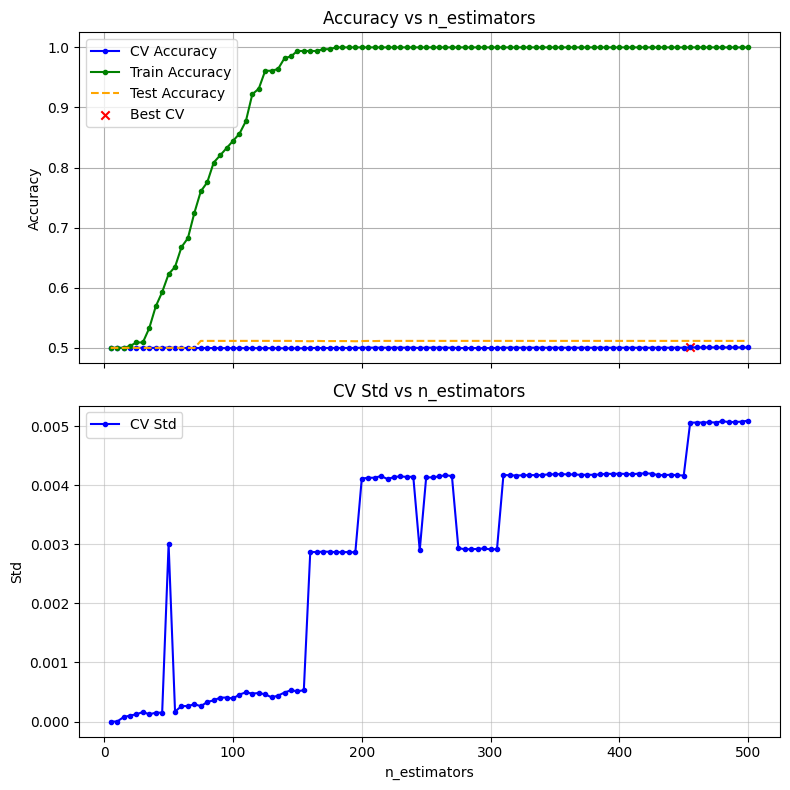

Execution Time: 00:02:14


In [ ]:



best_params = sweep_parameter(
    model=XGBClassifier,
    Parameters=Parameters_XG,
    param='n_estimators',
    parameter_list=list(range(5, 505, 5)),
    X_train=bdb_X_train_scaled,
    y_train=bdb_y_train,
    X_test=bdb_X_test_scaled,
    y_test=bdb_y_test,
    n_repeats=5,
    n_jobs=-1,
)

Yikes, so it looks like we're still overfitting, (as evidenced by the quick climb in Training Accuracy, but the stagnant test and CV Accuracies) let's try some other hyperparameter knobs and see if that helps the situation.

In [86]:
Default_Parameters_XGBoost = {
    'n_estimators'         : 100,        # Number of boosting rounds (trees). Higher = more complex model.
    'learning_rate'        : 0.3,        # Step size shrinkage used in update to prevent overfitting (0.01–0.3 typical).
    'max_depth'            : 6,          # Maximum depth of each tree. Higher = more complex, risk of overfitting.
    'min_child_weight'     : 1,      #    # Minimum sum of instance weight (hessian) needed in a child. Larger = more conservative.
    'subsample'            : 1.0,        # Fraction of samples used per tree (for bagging). <1.0 prevents overfitting.
    'colsample_bytree'     : 1.0,        # Fraction of features (columns) sampled per tree. <1.0 decorrelates trees.
    'gamma'                : 0.0,        # Minimum loss reduction required to split a leaf node (regularization term).
    'reg_alpha'            : 0.0,        # L1 regularization term on weights (feature selection effect).
    'scale_pos_weight'     : 1.0,        # Balancing of positive and negative weights for imbalanced classes.
    'objective'            : 'binary:logistic', # Default for classification; change for regression or multi-class.
    'booster'              : 'gbtree',   # Type of booster ('gbtree', 'gblinear', or 'dart').
    'tree_method'          : 'hist',     # Algorithm for building trees ('hist' is fast and memory-efficient).
    'sampling_method'      : 'uniform',  # How samples are chosen when subsampling ('uniform' or 'gradient_based').
    'random_state'         : 42,         # Random seed for reproducibility.
    'eval_metric'          : 'aucpr',
}

Sweeping max_depth: 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]


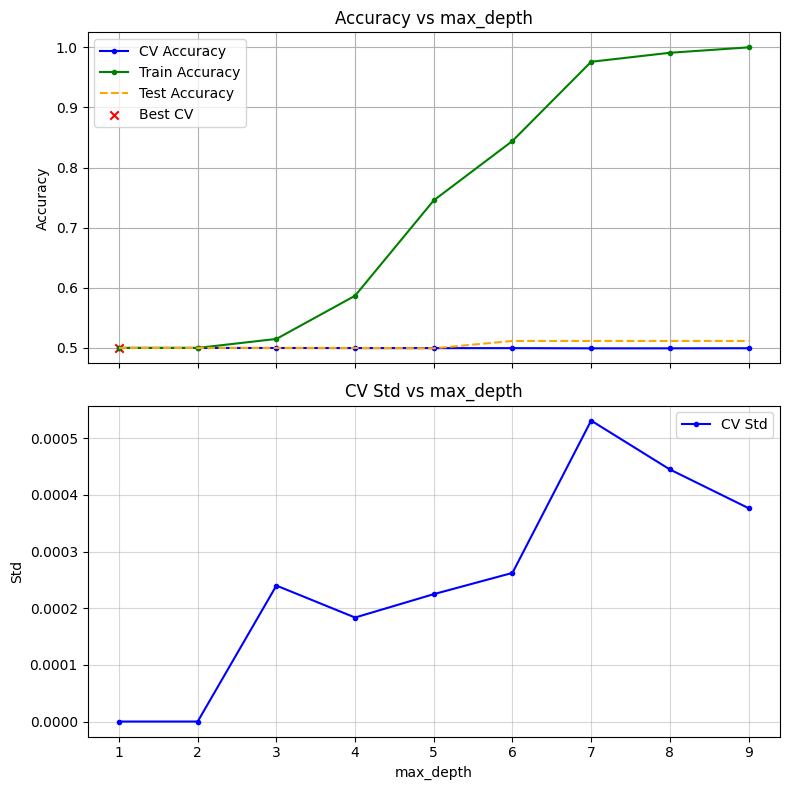

Execution Time: 00:00:06


Sweeping min_child_weight: 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]


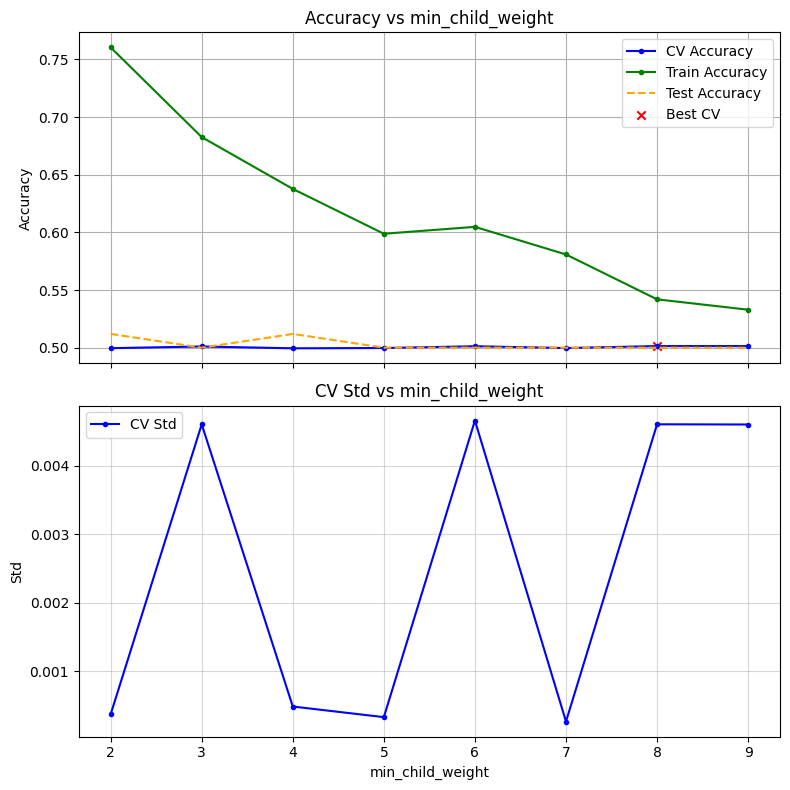

Execution Time: 00:00:03


Sweeping subsample: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


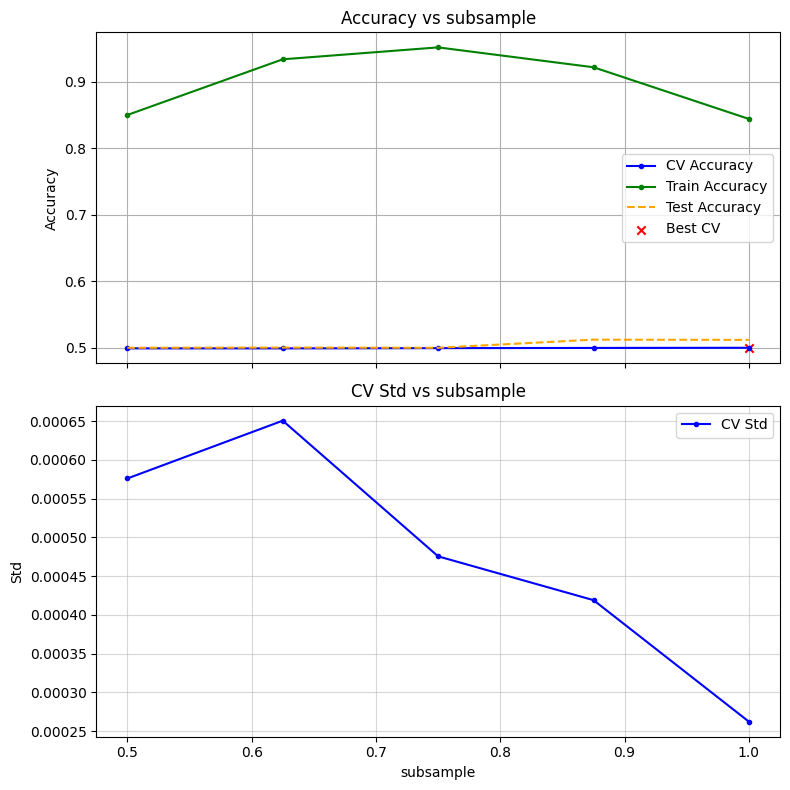

Execution Time: 00:00:02


Sweeping colsample_bytree: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


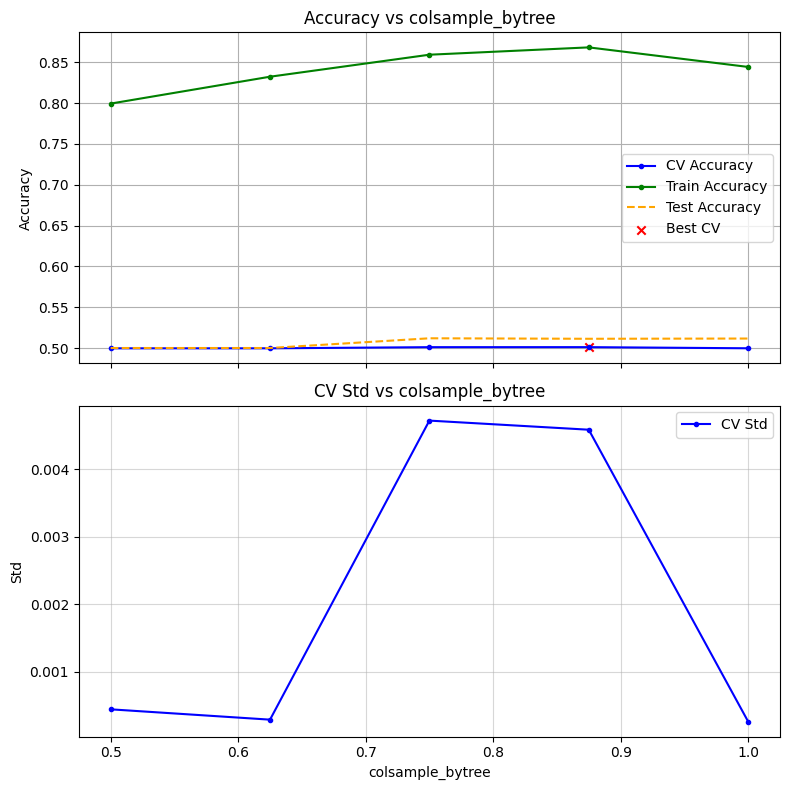

Execution Time: 00:00:02


Sweeping learning_rate: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


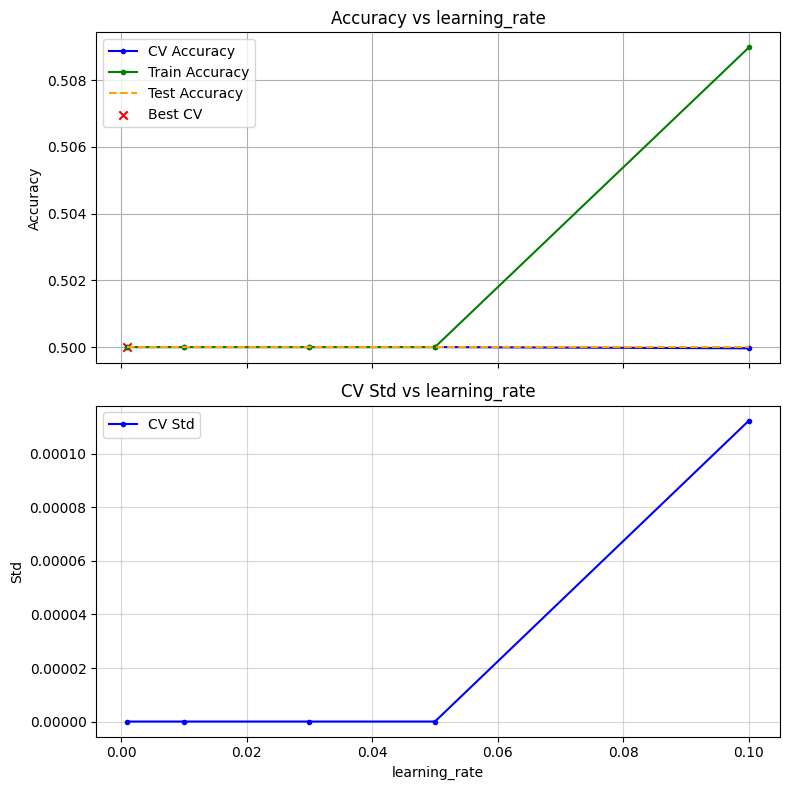

Execution Time: 00:00:02


Sweeping reg_lambda: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


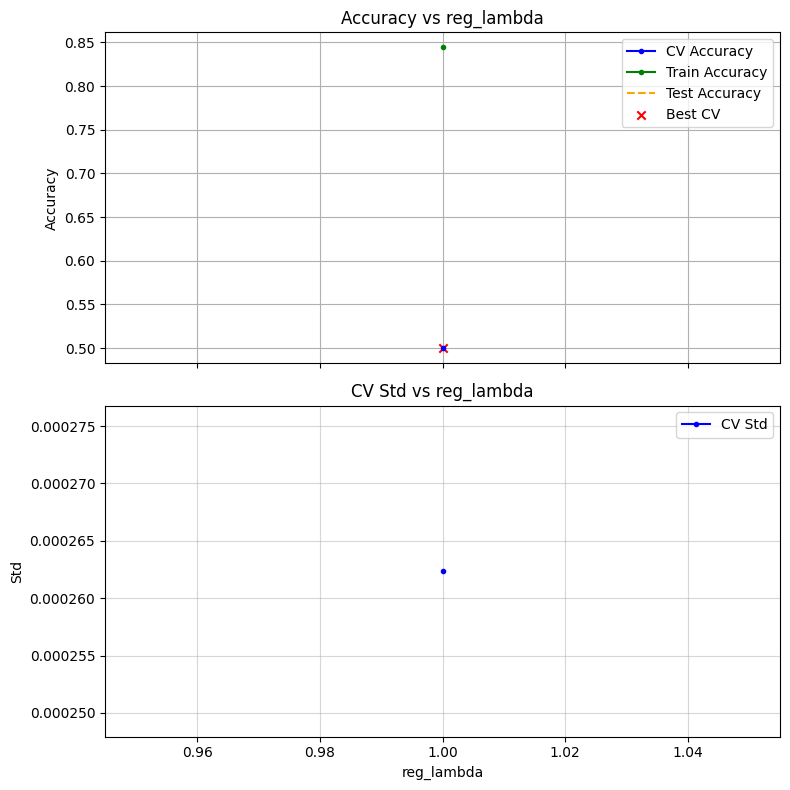

Execution Time: 00:00:00


Sweeping gamma: 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]


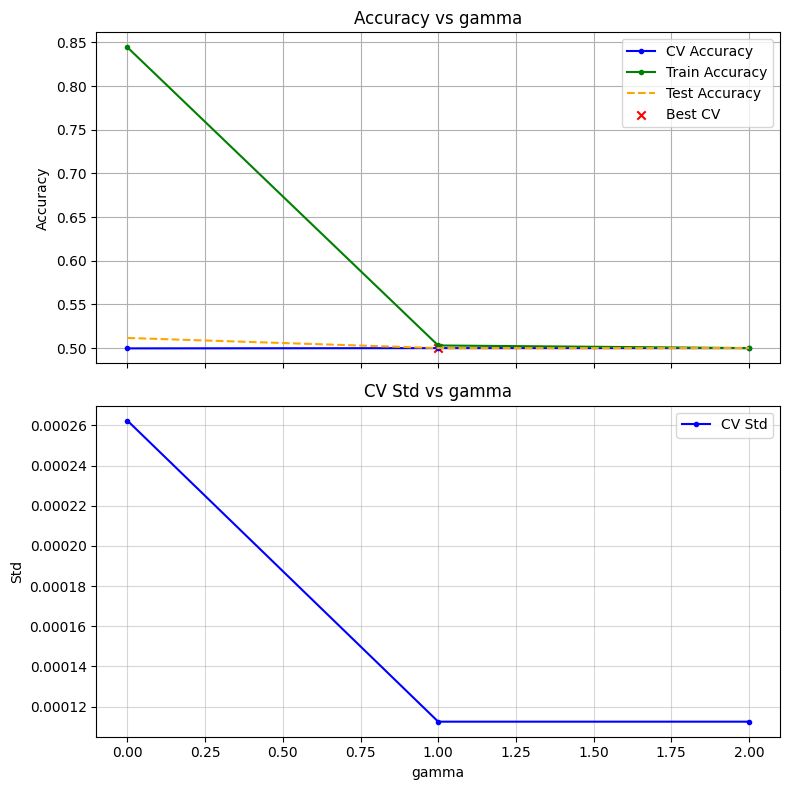

Execution Time: 00:00:01


,n_estimators,learning_rate,max_depth,min_child_weight,subsample,colsample_bytree,gamma,reg_alpha,scale_pos_weight,objective,booster,tree_method,sampling_method,random_state,eval_metric
0,100,0.3,6,1,1.0,1.0,0.0,0.0,1.0,binary:logistic,gbtree,hist,uniform,42,aucpr


In [90]:
start = time.time()

parameters_and_ranges = [
    ('max_depth', list(range(1, 10, 1))),
    ('min_child_weight', list(range(2, 10, 1))),
    ('subsample', list(np.linspace(0.5,1.0, 5))),
    ('colsample_bytree', list(np.linspace(0.5,1.0, 5))),
    ('learning_rate', [1e-3, 1e-2, 3e-2, 5e-2, .1]),
    ('reg_lambda', list(range(1,5,5))),
    ('gamma', [0, 1, 2]),
]


for param, parameter_list in parameters_and_ranges:
    Parameters_RF = sweep_parameter(
        XGBClassifier,  
        Parameters_XG,
        param,
        parameter_list,
        X_train=bdb_X_train_scaled,
        y_train=bdb_y_train,
        X_test=bdb_X_test_scaled,
        y_test=bdb_y_test,
        n_jobs=-1,
        n_repeats=2
    )

Params_XG_List.append(Parameters_XG)
pd.DataFrame(Params_XG_List)

From that first pass on the hyperparameter sweep, we have a better picture of what values in these  Now, let's try to adjust our hyperparameters to avoid the over fitting and then do more parameter sweeps. 

In [58]:
Adjusted_Params_XGBoost = {
    'n_estimators'         : 600,        # Number of boosting rounds (trees). Higher = more complex model.
    'learning_rate'        : 0.03,        # Adjusted learning rate
    'max_depth'            : 3,          # Adjusted max depth. 
    'min_child_weight'     : 6,          # Adjusted Min Child Weight
    'subsample'            : 0.75,       # Adjusted subsample 
    'colsample_bytree'     : 0.75,       # Adjusted colsample 
    'gamma'                : 1.0,        # Adjusted gamma
    'reg_lambda'           : 3.0,        # Adjusted L2 Regularization
    'reg_alpha'            : 0.2,        # Adjusted L1 Regularization
    'scale_pos_weight'     : 39.0,        # Balancing of positive and negative weights for imbalanced classes.
    'objective'            : 'binary:logistic', # Default for classification; change for regression or multi-class.
    'booster'              : 'gbtree',   # Type of booster ('gbtree', 'gblinear', or 'dart').
    'tree_method'          : 'hist',     # Algorithm for building trees ('hist' is fast and memory-efficient).
    'sampling_method'      : 'uniform',  # How samples are chosen when subsampling ('uniform' or 'gradient_based').
    'random_state'         : 42,         
    'eval_metric'          : 'aucpr',
}

Sweeping subsample: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


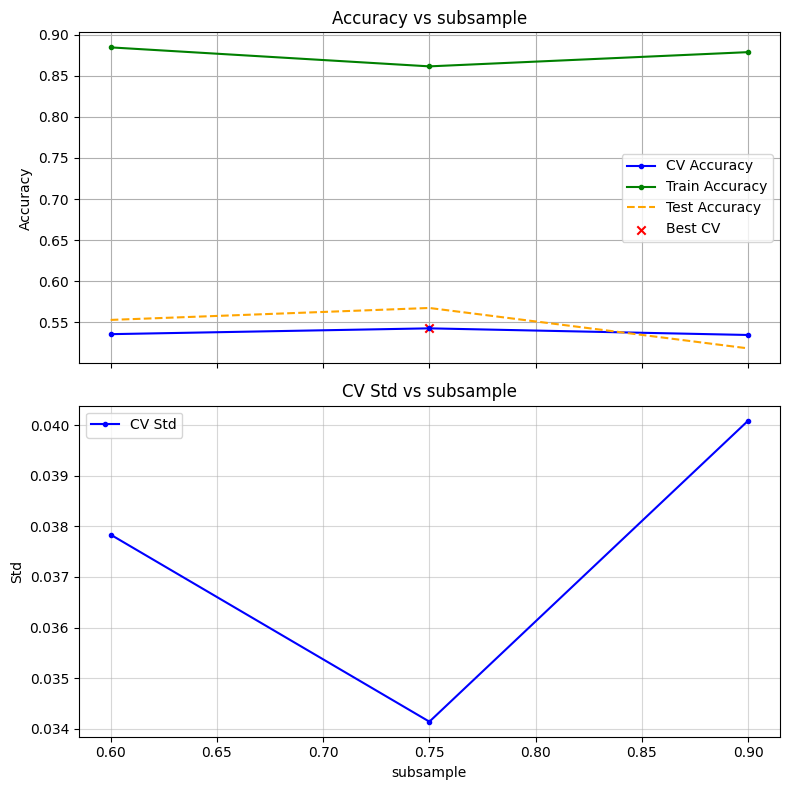

Execution Time: 00:00:03


Sweeping colsample_bytree: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]


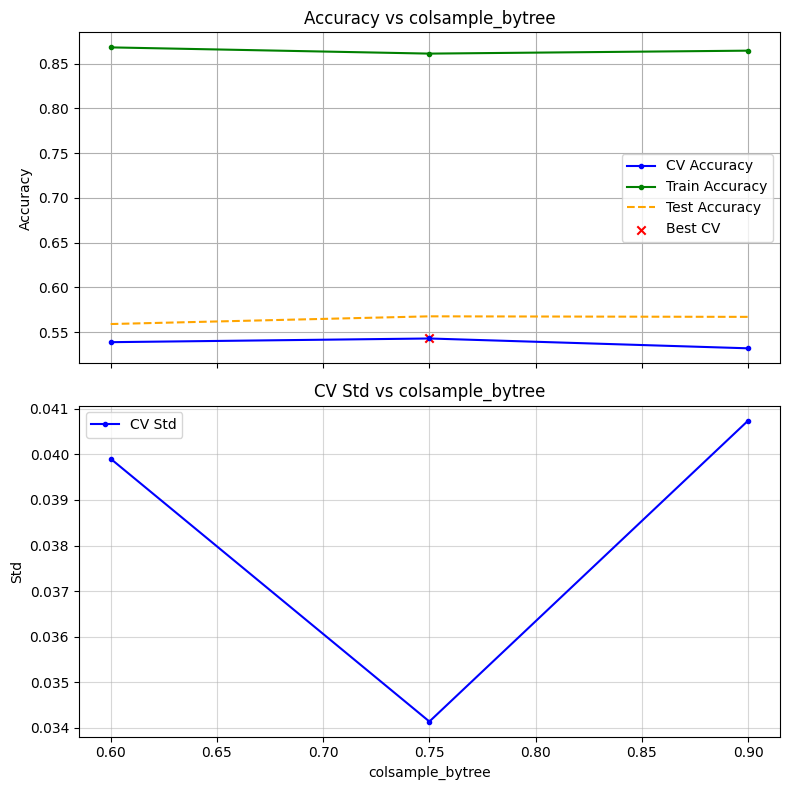

Execution Time: 00:00:03


,n_estimators,learning_rate,max_depth,min_child_weight,subsample,colsample_bytree,gamma,reg_lambda,reg_alpha,scale_pos_weight,objective,booster,tree_method,sampling_method,random_state,eval_metric,accuracy_found
0,600,0.03,3,6,0.75,0.75,1.0,3.0,0.2,39.0,binary:logistic,gbtree,hist,uniform,42,aucpr,0.542853
1,600,0.03,3,6,0.75,0.75,1.0,3.0,0.2,39.0,binary:logistic,gbtree,hist,uniform,42,aucpr,0.542853


In [61]:
start = time.time()

parameters_and_ranges = [
    # ('sampling_method', ['uniform', 'gradient_based']),
    ('subsample', [0.6, 0.75, 0.9]),
    ('colsample_bytree', [0.6, 0.75, 0.9]),
]

# make sure this starts as a dict
Parameters_XG_adj = Adjusted_Params_XGBoost.copy()
Params_XG_adj_List = []

for param, parameter_list in parameters_and_ranges:
    Parameters_XG_adj = sweep_parameter(
        model=XGBClassifier,           
        Parameters=Parameters_XG_adj,  
        param=param,
        parameter_list=parameter_list,
        X_train=bdb_X_train_scaled,
        y_train=bdb_y_train,
        X_test=bdb_X_test_scaled,
        y_test=bdb_y_test,
        n_jobs=-1,
        n_repeats=2,
        verbose=True
    )
    # optional snapshot per step
    Params_XG_adj_List.append(Parameters_XG_adj.copy())

pd.DataFrame(Params_XG_adj_List)

At this point, no matter what our parameter sweeps do, we cannot achieve above a 55 percent balanced accuracy rate. I'll still do a final test, but I don't think that we will be able to get any more meaningful gains out of XGBoost. 

In [36]:
params_ = {
    'n_estimators'         : 600,        
    'learning_rate'        : 0.03,       
    'max_depth'            : 3,          
    'min_child_weight'     : 6,          
    'subsample'            : 0.75,       
    'colsample_bytree'     : 0.75,       
    'gamma'                : 1.0,        
    'reg_lambda'           : 3.0,        
    'reg_alpha'            : 0.2,        
    'scale_pos_weight'     : 39.0,        
    'objective'            : 'binary:logistic', 
    'booster'              : 'gbtree',   
    'tree_method'          : 'hist',     
    'sampling_method'      : 'uniform',  
    'eval_metric'          : 'aucpr',
    'random_state'         : 42,         
    
}

BDB_XGBoost_Tuned = run_model_classifier(
    XGBClassifier,
    bdb_X_train_scaled, 
    bdb_y_train, 
    bdb_X_test_scaled,
    bdb_y_test,
    n_repeats=5, 
    n_jobs=-1, 
    run_comment='BDB XGBoost Tuned', 
    return_model=False,
    concat_results=True,
    **params_
    )





BDB_XGBoost_Tuned

,model,model_params,mean_cv_accuracy,std_cv_accuracy,train_accuracy,test_accuracy,balanced_train_accuracy,balanced_test_accuracy,run_comment
0,XGBClassifier,"{'objective': 'binary:logistic', 'base_score':...",0.820412,0.012465,0.826144,0.835673,0.861272,0.567617,BDB XGBoost Tuned


And then after this test, I had a brief conversation with ChatGPT to see if there was anything missing, or any tweaks to our hyperparameters we could add more. 

It told me to compute the class imbalance exactly (instead of just estimating it) and then add that in. 

In [37]:
scale_pos_weight = (len(bdb_y_train) - sum(bdb_y_train)) / sum(bdb_y_train)
scale_pos_weight

39.952095808383234

And then it suggested tweaking the hyperparameters in the following way as well to attempt to get more model performance. 
- Transcript: https://chatgpt.com/share/6907a20c-cd34-800f-beab-9b8bc5869904

In [38]:
params_ = {
    'n_estimators'       : 600,            # plenty of rounds + early stopping
    'learning_rate'      : 0.03,           # low LR for smooth convergence
    'max_depth'          : 3,              # shallow trees to prevent overfit
    'min_child_weight'   : 6,              # moderate split constraint
    'subsample'          : 0.7,            # random row sampling
    'colsample_bytree'   : 0.7,            # random feature sampling
    'colsample_bynode'   : 0.8,            # extra diversity between trees
    'gamma'              : 1.0,            # maintain pruning regularization
    'reg_lambda'         : 3.0,            # L2 regularization
    'reg_alpha'          : 0.1,            # lighter L1 to improve recall
    'max_delta_step'     : 1,              # stabilizes updates for imbalance
    'scale_pos_weight'   : scale_pos_weight, # use true imbalance ratio
    'booster'            : 'gbtree',       # standard tree booster
    'tree_method'        : 'hist',         # efficient histogram method
    'sampling_method'    : 'uniform',
    'objective'          : 'binary:logistic',
    'eval_metric'        : 'aucpr',        # precision-recall AUC for imbalance
    'random_state'       : 42,
}



BDB_XGBoost_Tuned_2 = run_model_classifier(
    XGBClassifier,
    BDB_PCA_X_train_scaled, 
    BDB_PCA_y_train, 
    BDB_PCA_X_test_scaled,
    BDB_PCA_y_test,
    n_repeats=5, 
    n_jobs=-1, 
    run_comment='BDB XGBoost Tuned Again', 
    return_model=False,
    concat_results=True,
    **params_
    )

BDB_XGBoost_Tuned_2

,model,model_params,mean_cv_accuracy,std_cv_accuracy,train_accuracy,test_accuracy,balanced_train_accuracy,balanced_test_accuracy,run_comment
0,XGBClassifier,"{'objective': 'binary:logistic', 'base_score':...",0.842491,0.012113,0.850563,0.829825,0.885463,0.576225,BDB XGBoost Tuned Again


Yep, even though this reduced overfitting on the training accuracy and CV metrics, we are still getting a balanced test accuracy of around 57%, which is barely an improvement over what we had before. At this point, let's move onto Category Boosting as an esemble model 

### **First and Future**

In [ ]:
def sweep_parameter(
    model_class,
    base_params,
    param_name,
    param_values,
    X_train,
    y_train,
    X_test=None,
    y_test=None,
    n_repeats=2,
    n_splits=5,
    n_jobs=-1,
):
    from sklearn.model_selection import RepeatedStratifiedKFold
    import numpy as np
    import pandas as pd

    # Ensure pandas objects
    if not isinstance(X_train, pd.DataFrame):
        X_train = pd.DataFrame(X_train)
    if not isinstance(y_train, (pd.Series, pd.DataFrame)):
        y_train = pd.Series(y_train)

    cv = RepeatedStratifiedKFold(
        n_splits=n_splits,
        n_repeats=n_repeats,
        random_state=42
    )

    results = []

    for val in param_values:
        params = base_params.copy()
        params[param_name] = val

        scores = []

        for train_idx, valid_idx in cv.split(X_train, y_train):
            X_tr = X_train.iloc[train_idx]    # ✅ row indexing fix from ChatGPT:
            X_val = X_train.iloc[valid_idx]
            y_tr = y_train.iloc[train_idx]
            y_val = y_train.iloc[valid_idx]

            model = model_class(**params)
            model.fit(X_tr, y_tr)
            scores.append(model.score(X_val, y_val))

        results.append({
            param_name: val,
            "mean_score": np.mean(scores),
            "std_score": np.std(scores),
        })

    return pd.DataFrame(results)

In [24]:
start = time.time()

parameters_and_ranges = [
    ('max_depth', list(range(1, 10, 1))),
    ('min_child_weight', list(range(2, 10, 1))),
    ('subsample', list(np.linspace(0.5,1.0, 5))),
    ('colsample_bytree', list(np.linspace(0.5,1.0, 5))),
    ('learning_rate', [1e-3, 1e-2, 3e-2, 5e-2, .1]),
    ('reg_lambda', list(range(1,5,5))),
    ('gamma', [0, 1, 2]),
]


for param, parameter_list in parameters_and_ranges:
    Parameters_RF = sweep_parameter(
        XGBClassifier,  
        Parameters_XG,
        param,
        parameter_list,
        X_train=fnf_X_train_scaled,
        y_train=fnf_y_train,
        X_test=fnf_X_test_scaled,
        y_test=fnf_y_test,
        n_jobs=-1,
        n_repeats=2
    )

Params_XG_List.append(Parameters_XG)
pd.DataFrame(Params_XG_List)

,n_estimators,learning_rate,max_depth,min_child_weight,subsample,colsample_bytree,gamma,reg_alpha,scale_pos_weight,objective,booster,tree_method,sampling_method,random_state
0,100,0.3,6,1,1.0,1.0,0.0,0.0,1.0,binary:logistic,gbtree,hist,uniform,42


In [44]:
A = len(fnf_y_train)
B = sum(fnf_y_train)

scale_pos_weight = (A - B) / B
scale_pos_weight

3444.2258064516127

In [45]:
params_ = {
    'n_estimators'       : 100,            # plenty of rounds + early stopping
    'learning_rate'      : 0.03,           # low LR for smooth convergence
    'max_depth'          : 6,              # shallow trees to prevent overfit
    'min_child_weight'   : 1,              # moderate split constraint
    'subsample'          : 1.0,            # random row sampling
    'colsample_bytree'   : 1.0,            # random feature sampling
    'colsample_bynode'   : 0.8,            # extra diversity between trees
    'gamma'              : 0.0,            # maintain pruning regularization
    'reg_lambda'         : 3.0,            # L2 regularization
    'reg_alpha'          : 0.0,            # lighter L1 to improve recall
    'max_delta_step'     : 1,              # stabilizes updates for imbalance
    'scale_pos_weight'   : scale_pos_weight, # use true imbalance ratio
    'booster'            : 'gbtree',       # standard tree booster
    'tree_method'        : 'hist',         # efficient histogram method
    'sampling_method'    : 'uniform',
    'objective'          : 'binary:logistic',
    'eval_metric'        : 'aucpr',        # precision-recall AUC for imbalance
    'random_state'       : 42,
}



FNF_XGBoost_Tuned = run_model_classifier(
    XGBClassifier,
    fnf_X_train_scaled, 
    fnf_y_train, 
    fnf_X_test_scaled,
    fnf_y_test,
    n_repeats=5, 
    n_jobs=-1, 
    run_comment='FNF XGBoost Tuned ', 
    return_model=False,
    concat_results=True,
    **params_
    )

FNF_XGBoost_Tuned

,model,model_params,mean_cv_accuracy,std_cv_accuracy,train_accuracy,test_accuracy,balanced_train_accuracy,balanced_test_accuracy,run_comment
0,XGBClassifier,"{'objective': 'binary:logistic', 'base_score':...",0.940123,0.012245,0.913845,0.912962,0.95691,0.523257,FNF XGBoost Tuned


### **PDA XGBoost**

In [32]:
start = time.time()

parameters_and_ranges = [
    ('max_depth', list(range(1, 10, 1))),
    ('min_child_weight', list(range(2, 10, 1))),
    ('subsample', list(np.linspace(0.5,1.0, 5))),
    ('colsample_bytree', list(np.linspace(0.5,1.0, 5))),
    ('learning_rate', [1e-3, 1e-2, 3e-2, 5e-2, .1]),
    ('reg_lambda', list(range(1,5,5))),
    ('gamma', [0, 1, 2]),
]


for param, parameter_list in parameters_and_ranges:
    Parameters_RF = sweep_parameter(
        XGBClassifier,  
        Parameters_XG,
        param,
        parameter_list,
        X_train=pda_X_train_scaled,
        y_train=pda_y_train,
        X_test=pda_X_test_scaled,
        y_test=pda_y_test,
        n_jobs=-1,
        n_repeats=2
    )

Params_XG_List.append(Parameters_XG)
pd.DataFrame(Params_XG_List)

,n_estimators,learning_rate,max_depth,min_child_weight,subsample,colsample_bytree,gamma,reg_alpha,scale_pos_weight,objective,booster,tree_method,sampling_method,random_state
0,100,0.3,6,1,1.0,1.0,0.0,0.0,1.0,binary:logistic,gbtree,hist,uniform,42
1,100,0.3,6,1,1.0,1.0,0.0,0.0,1.0,binary:logistic,gbtree,hist,uniform,42


In [46]:
A = len(pda_y_train)
B = sum(pda_y_train)

scale_pos_weight = (A - B) / B
scale_pos_weight

71.21621621621621

In [52]:
params_ = {
    'n_estimators'       : 100,            # plenty of rounds + early stopping
    'learning_rate'      : 0.03,           # low LR for smooth convergence
    'max_depth'          : 6,              # shallow trees to prevent overfit
    'min_child_weight'   : 1,              # moderate split constraint
    'subsample'          : 1.0,            # random row sampling
    'colsample_bytree'   : 1.0,            # random feature sampling
    'colsample_bynode'   : 0.8,            # extra diversity between trees
    'gamma'              : 0.0,            # maintain pruning regularization
    'reg_lambda'         : 3.0,            # L2 regularization
    'reg_alpha'          : 0.0,            # lighter L1 to improve recall
    'max_delta_step'     : 1,              # stabilizes updates for imbalance
    'scale_pos_weight'   : scale_pos_weight, # use true imbalance ratio
    'booster'            : 'gbtree',       # standard tree booster
    'tree_method'        : 'hist',         # efficient histogram method
    'sampling_method'    : 'uniform',
    'objective'          : 'binary:logistic',
    'eval_metric'        : 'aucpr',        # precision-recall AUC for imbalance
    'random_state'       : 42,
}



PDA_XGBoost_Tuned = run_model_classifier(
    XGBClassifier,
    pda_X_train_scaled, 
    pda_y_train, 
    pda_X_test_scaled,
    pda_y_test,
    n_repeats=5, 
    n_jobs=-1, 
    run_comment='PDA XGBoost Tuned ', 
    return_model=False,
    concat_results=True,
    **params_
    )

PDA_XGBoost_Tuned

,model,model_params,mean_cv_accuracy,std_cv_accuracy,train_accuracy,test_accuracy,balanced_train_accuracy,balanced_test_accuracy,run_comment
0,XGBClassifier,"{'objective': 'binary:logistic', 'base_score':...",0.812835,0.039468,0.781624,0.747195,0.889279,0.515689,PDA XGBoost Tuned


In [53]:
combined_results[combined_results['run_comment'].str.contains('XGBoost')][['model', 'mean_cv_accuracy', 'test_accuracy', 'balanced_test_accuracy', 'run_comment']]

,model,mean_cv_accuracy,test_accuracy,balanced_test_accuracy,run_comment
0,XGBClassifier,0.820412,0.835673,0.567617,BDB XGBoost Tuned
1,XGBClassifier,0.842491,0.829825,0.576225,BDB XGBoost Tuned Again
2,XGBClassifier,0.940123,0.912962,0.523257,FNF XGBoost Tuned
3,XGBClassifier,0.812835,0.747195,0.515689,PDA XGBoost Tuned


___

## **Catboost**

In [67]:
def categorify(df, target_column: str ='Inj_Occured'):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Remove target if it’s numeric
    if target_column in numeric_cols:
        numeric_cols.remove(target_column)

    # Identify binary (0/1) columns among numeric ones
    def is_binary_01(s: pd.Series) -> bool:
        x = s.dropna().unique()
        if len(x) == 0:
            return False
        return set(pd.Series(x).astype(float)).issubset({0.0, 1.0}) and s.nunique(dropna=True) <= 2

    one_hot_cols = [c for c in numeric_cols if is_binary_01(df[c])]
    numeric_cols_to_scale = [c for c in numeric_cols if c not in one_hot_cols]

    # Seperate out categorical columns
    exclude = set(numeric_cols_to_scale + [target_column])
    categorical_cols = [c for c in df.columns if c not in exclude]

    return categorical_cols
    

In [68]:
cat_features_pre = categorify(BDB_All_Plays_Model_Ready, target_column='Inj_Occured')
cat_columns = BDB_All_Plays_Model_Ready[cat_features_pre].columns.to_list()

# And let's check just in case: 
for c in cat_columns: 
    print(c)


pff_playAction
foul_on_play
possessionTeam_ATL
possessionTeam_BAL
possessionTeam_BUF
possessionTeam_CAR
possessionTeam_CHI
possessionTeam_CIN
possessionTeam_CLE
possessionTeam_DAL
possessionTeam_DEN
possessionTeam_DET
possessionTeam_GB
possessionTeam_HOU
possessionTeam_IND
possessionTeam_JAX
possessionTeam_KC
possessionTeam_LA
possessionTeam_LAC
possessionTeam_LV
possessionTeam_MIA
possessionTeam_MIN
possessionTeam_NE
possessionTeam_NO
possessionTeam_NYG
possessionTeam_NYJ
possessionTeam_PHI
possessionTeam_PIT
possessionTeam_SEA
possessionTeam_SF
possessionTeam_TB
possessionTeam_TEN
possessionTeam_WAS
defensiveTeam_ATL
defensiveTeam_BAL
defensiveTeam_BUF
defensiveTeam_CAR
defensiveTeam_CHI
defensiveTeam_CIN
defensiveTeam_CLE
defensiveTeam_DAL
defensiveTeam_DEN
defensiveTeam_DET
defensiveTeam_GB
defensiveTeam_HOU
defensiveTeam_IND
defensiveTeam_JAX
defensiveTeam_KC
defensiveTeam_LA
defensiveTeam_LAC
defensiveTeam_LV
defensiveTeam_MIA
defensiveTeam_MIN
defensiveTeam_NE
defensiveTeam_NO
d

In [69]:
Default_Parameters_Catboost = dict(
    iterations=1000,                 # with early stopping
    depth=6,
    learning_rate=0.06,
    l2_leaf_reg=3.0,
    loss_function="Logloss",
    eval_metric="AUC",
    auto_class_weights="Balanced",   # or use class_weights=[w0, w1]
    bootstrap_type="Bernoulli",      # needed if using 'subsample'
    subsample=0.8,                   # row subsampling
    rsm=0.8,                         # col subsampling (feature sampling)
    # bagging_temperature=0.5,         # strength of sampling
    random_state=42,
    verbose=False,
    thread_count=-1, 
    cat_features=cat_columns,
)

In [ ]:
start = time.time()

parameters_and_ranges = [
    ("subsample", [0.6, 0.75, 0.9]),         # row sampling
    ("rsm", [0.6, 0.75, 0.9]),               # col sampling
    # ("bagging_temperature", [0.0, 0.5, 1.0]), # sampling strength
    ("depth", [4, 6, 8]),
    ("learning_rate", [0.02, 0.06, 0.1]),
    ("l2_leaf_reg", [1, 3, 10]),
]

# Was getting weird errors to turned these into numpy Arrays
Xtr = getattr(bdb_X_train_scaled, "to_numpy", lambda: bdb_X_train_scaled)()
Xte = getattr(bdb_X_test_scaled, "to_numpy", lambda: bdb_X_test_scaled)()

Parameters_CatBoost_Adj = Default_Parameters_Catboost.copy()
Params_Catboost_Adj_List = []

for param, parameter_list in parameters_and_ranges:
    Parameters_CatBoost_Adj = sweep_parameter(
        model=CatBoostClassifier,           
        Parameters=Parameters_CatBoost_Adj,  
        param=param,
        parameter_list=parameter_list,
        X_train=Xtr,
        y_train=bdb_y_train,
        X_test=Xte,
        y_test=bdb_y_test,
        n_jobs=-1,
        n_repeats=2,
        verbose=True
    )
    # optional snapshot per step
    Params_Catboost_Adj_List.append(Parameters_CatBoost_Adj.copy())

pd.DataFrame(Params_Catboost_Adj_List)


Nice! We've actually managed to push it into a somewhat - reasonable range. Let's use the best of each run as a starting point for some more tuning. 

In [60]:
params_ = dict(
    iterations=1000,                 # with early stopping
    depth=4,
    learning_rate=0.1,
    l2_leaf_reg=10.0,
    loss_function="Logloss",
    eval_metric="AUC",
    auto_class_weights="Balanced",   
    bootstrap_type="Bernoulli",      
    subsample=0.6,                  
    rsm=0.75,                         
    random_state=42,
    verbose=False,
    thread_count=-1, 
    # cat_features=cat_columns,
)



BDB_Cat_Train_Tuned = run_model_classifier(
    CatBoostClassifier,           
    Xtr, 
    BDB_PCA_y_train, 
    Xte,
    BDB_PCA_y_test,
    n_repeats=5, 
    n_jobs=-1, 
    run_comment='BDB CatBoost Baseline - Tuned', 
    return_model=False,
    concat_results=True,
    **params_
    )

BDB_Cat_Train_Tuned


,model,model_params,mean_cv_accuracy,std_cv_accuracy,train_accuracy,test_accuracy,balanced_train_accuracy,balanced_test_accuracy,run_comment
0,CatBoostClassifier,"{'iterations': 1000, 'learning_rate': 0.1, 'de...",0.956222,0.004344,0.986109,0.950877,0.992881,0.522225,BDB CatBoost Baseline - Tuned


It still looks like we're overfitting. Let's get more aggressive with the parameter regularization techniques and:
- dial up regularization
- dial down learning rate
- dial down depth

In [61]:
params_ = dict(
    iterations=1000,                 # with early stopping
    depth=3,
    learning_rate=0.05,
    l2_leaf_reg=25.0,
    loss_function="Logloss",
    eval_metric="AUC",
    auto_class_weights="Balanced",   
    bootstrap_type="Bernoulli",      
    subsample=0.6,                  
    rsm=0.75,                         
    random_state=42,
    verbose=False,
    thread_count=-1, 
    # cat_features=cat_columns,
)



BDB_Cat_Train_Tuned = run_model_classifier(
    CatBoostClassifier,           
    Xtr, 
    BDB_PCA_y_train, 
    Xte,
    BDB_PCA_y_test,
    n_repeats=5, 
    n_jobs=-1, 
    run_comment='BDB CatBoost Tuned', 
    return_model=False,
    concat_results=True,
    **params_
    )

BDB_Cat_Train_Tuned

,model,model_params,mean_cv_accuracy,std_cv_accuracy,train_accuracy,test_accuracy,balanced_train_accuracy,balanced_test_accuracy,run_comment
0,CatBoostClassifier,"{'iterations': 1000, 'learning_rate': 0.05, 'd...",0.856324,0.008973,0.876151,0.830994,0.930688,0.611639,BDB CatBoost Tuned


And we're hitting around a 61% balanced accuracy again. 


#### **Cat Boost with normal categories**

because the model has it's own methodology for handling cat variables, here we investigate if putting these into the pipeline unedited helps.

In [82]:
BDB_All_Plays_Clean = pd.read_csv("../../Feature_Subsets/BDB_All_Plays_Clean.csv", index_col=False)

In [84]:
BDB_All_Plays_Clean.drop(columns=['Unnamed: 0', 'possessionTeam','defensiveTeam', 'yardlineSide'], inplace=True)

In [83]:
BDB_All_Plays_Clean.columns

Index(['Unnamed: 0', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'preSnapHomeScore',
       'preSnapVisitorScore', 'passResult', 'penaltyYards',
       'prePenaltyPlayResult', 'playResult', 'absoluteYardlineNumber',
       'offenseFormation', 'personnelO', 'defendersInBox', 'personnelD',
       'dropBackType', 'pff_playAction', 'pff_passCoverage',
       'pff_passCoverageType', 'Inj_Occured', 'foul_on_play',
       'frac_quarter_elapsed'],
      dtype='object')

In [ ]:
BDB_All_Plays_Clean.drop(columns=['Unnamed: 0', 'possessionTeam','defensiveTeam', 'yardlineSide'], inplace=True)

In [35]:
BDB_All_Plays_Clean.columns

Index(['quarter', 'down', 'yardsToGo', 'yardlineNumber', 'preSnapHomeScore',
       'preSnapVisitorScore', 'passResult', 'penaltyYards',
       'prePenaltyPlayResult', 'playResult', 'absoluteYardlineNumber',
       'offenseFormation', 'personnelO', 'defendersInBox', 'personnelD',
       'dropBackType', 'pff_playAction', 'pff_passCoverage',
       'pff_passCoverageType', 'Inj_Occured', 'foul_on_play',
       'frac_quarter_elapsed'],
      dtype='object')

In [85]:
def train_test_split_df(df, feature_cols, target_column):
    feature_cols = feature_cols
    target_column = target_column

    X = df[feature_cols]
    y = df[target_column].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )
    return X_train, X_test, y_train, y_test

In [86]:
cat_cols = [
            'passResult', 
            'offenseFormation',
            'personnelO',
            'personnelD',
            'dropBackType', 
            'pff_passCoverage',
            'pff_passCoverageType'
         ]

target_column = 'Inj_Occured'


bdb_X_train, bdb_X_test, bdb_y_train, bdb_y_test = train_test_split_df(BDB_All_Plays_Clean, cat_cols, target_column)

In [99]:
cat_cols = [
            'passResult', 
            'offenseFormation',
            'personnelO',
            'personnelD',
            'dropBackType', 
            'pff_passCoverage',
            'pff_passCoverageType'
         ]


params_ = dict(
    iterations=1000,                 # with early stopping
    depth=3,
    learning_rate=0.05,
    l2_leaf_reg=25.0,
    loss_function="Logloss",
    eval_metric="AUC",
    auto_class_weights="Balanced",   
    bootstrap_type="Bernoulli",      
    subsample=0.6,                  
    rsm=0.75,                         
    random_state=42,
    verbose=False,
    thread_count=-1, 
    cat_features=cat_cols,
)



BDB_Cat_again= run_model_classifier(
    CatBoostClassifier,           
    bdb_X_train, 
    bdb_y_train, 
    bdb_X_test,
    bdb_y_test,
    n_repeats=5, 
    n_jobs=-1, 
    run_comment='BDB CatBoost Raw Cat Var Tuned', 
    return_model=False,
    concat_results=True,
    **params_
    )

BDB_Cat_again

,model,model_params,mean_cv_accuracy,std_cv_accuracy,train_accuracy,test_accuracy,balanced_train_accuracy,balanced_test_accuracy,run_comment
0,CatBoostClassifier,"{'iterations': 1000, 'learning_rate': 0.05, 'd...",0.667932,0.039039,0.687235,0.670175,0.649964,0.5176,BDB CatBoost Raw Cat Var Tuned


#### **First and Future**

In [89]:
FNF_All_Plays = pd.read_csv("../../Feature_Subsets/FNF_All_Plays_NON_ONE_HOT.csv", index_col=False)
FNF_All_Plays.drop(columns="Unnamed: 0", inplace=True)

In [90]:
FNF_All_Plays_Categorical_Cols = ['StadiumType',
                                                'FieldType',
                                                'Weather',
                                                'PlayType',
                                                'Position']
FNF_All_Plays_Target = ['Inj_Occured']


FNF_X_train, FNF_X_test, FNF_y_train, FNF_y_test = train_test_split_df(FNF_All_Plays, FNF_All_Plays_Categorical_Cols, FNF_All_Plays_Target)

In [92]:
params_ = dict(
    iterations=1000,                 # with early stopping
    depth=3,
    learning_rate=0.05,
    l2_leaf_reg=25.0,
    loss_function="Logloss",
    eval_metric="AUC",
    auto_class_weights="Balanced",   
    bootstrap_type="Bernoulli",      
    subsample=0.6,                  
    rsm=0.75,                         
    random_state=42,
    verbose=False,
    thread_count=-1, 
    cat_features=FNF_All_Plays_Categorical_Cols,
)



FNF_Cat_Try_One = run_model_classifier(
    CatBoostClassifier,           
    FNF_X_train, 
    FNF_y_train, 
    FNF_X_test,
    FNF_y_test,
    n_repeats=5, 
    n_jobs=-1, 
    run_comment='FNF CatBoost Raw Cat Var', 
    return_model=False,
    concat_results=True,
    **params_
    )

FNF_Cat_Try_One

,model,model_params,mean_cv_accuracy,std_cv_accuracy,train_accuracy,test_accuracy,balanced_train_accuracy,balanced_test_accuracy,run_comment
0,CatBoostClassifier,"{'iterations': 1000, 'learning_rate': 0.05, 'd...",0.830792,0.00873,0.80234,0.801655,0.901141,0.534236,FNF CatBoost Raw Cat Var


#### **Punt Data Analytics**

In [93]:
PDA_All_Plays = pd.read_csv("../../Feature_Subsets/PDA_All_Plays.csv")
PDA_All_Plays.drop(columns='Unnamed: 0', inplace=True)

In [94]:
PDA_All_Plays

,Season_Year,Season_Type,Week,Game_Day,Game_Site,Start_Time,Visit_Team,StadiumType,Turf,GameWeather,Temperature,Quarter,Play_Type,Poss_Team,Inj_Occured,home_score,away_score,frac_quarter_elapsed,month,yardline_100
0,2016,Pre,2,Saturday,Los Angeles,17:00,Dallas Cowboys,Outdoors,Natural,Sunny,79.0,1,Punt,LA,0,7,0,0.17,August,47
1,2016,Pre,2,Saturday,Los Angeles,17:00,Dallas Cowboys,Outdoors,Natural,Sunny,79.0,2,Punt,LA,0,21,7,0.19,August,29
2,2016,Pre,2,Saturday,Los Angeles,17:00,Dallas Cowboys,Outdoors,Natural,Sunny,79.0,2,Punt,DAL,0,21,7,0.33,August,18
3,2016,Pre,2,Saturday,Los Angeles,17:00,Dallas Cowboys,Outdoors,Natural,Sunny,79.0,2,Punt,LA,0,24,7,0.98,August,54
4,2016,Pre,2,Saturday,Los Angeles,17:00,Dallas Cowboys,Outdoors,Natural,Sunny,79.0,3,Punt,DAL,0,24,14,0.30,August,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6676,2017,Post,3,Sunday,Philadelphia,18:00,Minnesota Vikings,Outdoors,Natural,Cloudy,47.0,2,Punt,MIN,0,7,14,0.19,January,33
6677,2017,Post,3,Sunday,Philadelphia,18:00,Minnesota Vikings,Outdoors,Natural,Cloudy,47.0,2,Punt,PHI,0,7,14,0.37,January,44
6678,2017,Post,3,Sunday,Philadelphia,18:00,Minnesota Vikings,Outdoors,Natural,Cloudy,47.0,2,Punt,MIN,0,7,21,0.96,January,47
6679,2017,Post,3,Sunday,Philadelphia,18:00,Minnesota Vikings,Outdoors,Natural,Cloudy,47.0,4,Punt,PHI,0,7,38,0.35,January,45


In [95]:
PDA_All_Plays_Cat = [
'Season_Type',
'Game_Day',
'Game_Site',
'Visit_Team',
'StadiumType',
'Turf',
'Poss_Team',
'month'
]
PDA_All_Plays_Target = ['Inj_Occured']

PDA_X_train, PDA_X_test, PDA_y_train, PDA_y_test = train_test_split_df(PDA_All_Plays, PDA_All_Plays_Cat, PDA_All_Plays_Target)


In [97]:
params_ = dict(
    iterations=1000,                 # with early stopping
    depth=3,
    learning_rate=0.05,
    l2_leaf_reg=25.0,
    loss_function="Logloss",
    eval_metric="AUC",
    auto_class_weights="Balanced",   
    bootstrap_type="Bernoulli",      
    subsample=0.6,                  
    rsm=0.75,                         
    random_state=42,
    verbose=False,
    thread_count=-1, 
    cat_features=PDA_All_Plays_Cat,
)



PDA_Cat_Try_One = run_model_classifier(
    CatBoostClassifier,           
    PDA_X_train, 
    PDA_y_train, 
    PDA_X_test,
    PDA_y_test,
    n_repeats=5, 
    n_jobs=-1, 
    run_comment='PDA CatBoost Raw Cat Var', 
    return_model=False,
    concat_results=True,
    **params_
    )

PDA_Cat_Try_One

,model,model_params,mean_cv_accuracy,std_cv_accuracy,train_accuracy,test_accuracy,balanced_train_accuracy,balanced_test_accuracy,run_comment
0,CatBoostClassifier,"{'iterations': 1000, 'learning_rate': 0.05, 'd...",0.896964,0.029617,0.892964,0.866866,0.62596,0.576342,PDA CatBoost Raw Cat Var


In [106]:
combined_results[combined_results['run_comment'].str.contains('CatBoost')][['model', 'mean_cv_accuracy', 'test_accuracy', 'balanced_test_accuracy', 'run_comment']].sort_values(by='balanced_test_accuracy', ascending=False).tail(6)

,model,mean_cv_accuracy,test_accuracy,balanced_test_accuracy,run_comment
9,CatBoostClassifier,0.896964,0.866866,0.576342,PDA CatBoost Raw Cat Var
8,CatBoostClassifier,0.830792,0.801655,0.534236,FNF CatBoost Raw Cat Var
4,CatBoostClassifier,0.956222,0.950877,0.522225,CatBoost Baseline - Tuned
5,CatBoostClassifier,0.956222,0.950877,0.522225,BDB CatBoost Baseline - Tuned
7,CatBoostClassifier,0.667932,0.670175,0.517600,BDB CatBoost Tuned
10,CatBoostClassifier,0.667932,0.670175,0.517600,BDB CatBoost Raw Cat Var Tuned


____

### **Results and Discussion**

At this point there are a number of different strategies that we could try to eek out greater performance gains across our model, but realistically I wouldn't expect more than a 10 percent performance gain with these models. (And I would say that 10 percent is generous.) 

At this point, we're better off hypertuning a logistic regression more for interpretability and then training a neural network to explore potential non-linear relationships that our tree based mode



“Context-level features such as personnel, formation, and coverage show some statistical dependence with injury occurrence (χ² tests), but they do not contain enough signal to support predictive modeling. The strongest correlational features (coverage, formation, drop back type) appear to capture team tendencies and exposure rather than injury biomechanics. Numeric play context variables show near-zero correlation with injury, confirming that contextual features alone are insufficient.

CatBoost, XGBoost, KNN, and logistic regression all collapse toward majority-class prediction, with balanced accuracies between 0.50–0.61. This indicates models cannot predict injuries from contextual features alone.”


So far as we can see: 


#### **Big Data Bowl:**
- Categorical Features: Weak Dependence (team level stats)
- Numeric: (Zero correlation)
- AI models: Majority class collapse
- Balanced Accuracy ~(50- 60%) on ALL

This is evidenced that NFL injury prediction cannot be done using team and play level contextual or static features alone, Biomechanics and time-series data are required to do this. 


The contextual Big Data Bowl injury dataset and the First & Future tracking dataset do not contain the information required to predict injuries.
Team-level and play-level variables describe strategy, not biomechanics, and thus do not meaningfully correlate with injury.
While injuries are fundamentally biomechanical events, the NGS tracking data cannot be aligned to the specific play instances where injuries occurred because the same play design appears multiple times throughout the season and the injury dataset lacks frame-level identifiers (gameId, playId, frameId, nflId).
As a result, true biomechanical variables such as player speed at collision, acceleration, orientation, distance to opponent, and force cannot be extracted.
This prevents any model from learning the causal mechanisms of injuries, leading all machine learning approaches to collapse toward majority-class predictions with balanced accuracies near 0.50.
